# PySATL Core: Usage Example

This notebook demonstrates the core capabilities of **PySATL Core**:

1. Registering built-in distribution families in the global registry.
2. Retrieving a family object from the registry and instantiating concrete distributions.
3. Querying and visualizing characteristics (PDF / CDF / PPF).
4. Sampling via inverse transform sampling.
5. Defining and registering a custom family with **multiple parametrizations**.
6. Using the characteristic graph to obtain missing characteristics.

Environment notes:
- **Python 3.12+** is required.
- A *family* is an **object** stored in the singleton `ParametricFamilyRegister`.


## Setup

PySATL provides configuration entry points that create family objects and register them:

- `configure_normal_family()` registers only the Normal family.
- `configure_families_register()` registers all built-in families shipped with the library.

You can access the registry without filling it by instantiating `ParametricFamilyRegister()`.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pysatl_core import (
    CharacteristicName,
    ContinuousSupport,
    FamilyName,
    ParametricFamily,
    ParametricFamilyRegister,
    Parametrization,
    UnivariateContinuous,
    configure_families_register,
    configure_normal_family,
    parametrization,
)

In [2]:
# Access the registry without configuring it
registry = ParametricFamilyRegister()
registry.list_registered_families()

[]

In [3]:
# Option A: register ONLY the Normal family
configure_normal_family()
registry.list_registered_families()

[<FamilyName.NORMAL: 'Normal'>]

In [4]:
# Option B: register ALL built-in families
configure_families_register()
registry.list_registered_families()

[<FamilyName.NORMAL: 'Normal'>,
 <FamilyName.EXPONENTIAL: 'Exponential'>,
 <FamilyName.CONTINUOUS_UNIFORM: 'ContinuousUniform'>]

## 1) Built-in family: Normal

A *concrete distribution* is obtained by fixing the parameters.

You can create it via:
- `family(...)` (uses the base parametrization by default), or
- `family.distribution(parametrization_name=..., **params)`.

The Normal family ships with multiple parametrizations:
- `meanStd` (base): `(mu, sigma)`
- `meanPrec`: `(mu, tau)` where `tau = 1 / sigma^2`
- `exponential`: `(a, b)` (an exponential-family form)


In [5]:
normal_family = ParametricFamilyRegister.get(FamilyName.NORMAL)
normal_family.name, normal_family.parametrization_names

(<FamilyName.NORMAL: 'Normal'>, ['meanStd', 'meanPrec', 'exponential'])

### Instantiating distributions in different parametrizations

Below we instantiate the **same distribution** in two parametrizations:

- `meanStd`: parameters `(mu, sigma)`
- `meanPrec`: parameters `(mu, tau)` where `tau = 1 / sigma^2`

We then compare their PDF and CDF curves (they should match). Actually, all the characteristics are computed via base parametrization (`meanStd`). Other parametrizations are being transformed to base while computing


In [6]:
d_mean_std = normal_family.distribution(parametrization_name="meanStd", mu=0.0, sigma=1.0)
d_mean_prec = normal_family.distribution(parametrization_name="meanPrec", mu=0.0, tau=1.0)
d_mean_std.parametrization_name, d_mean_prec.parametrization_name

('meanStd', 'meanPrec')

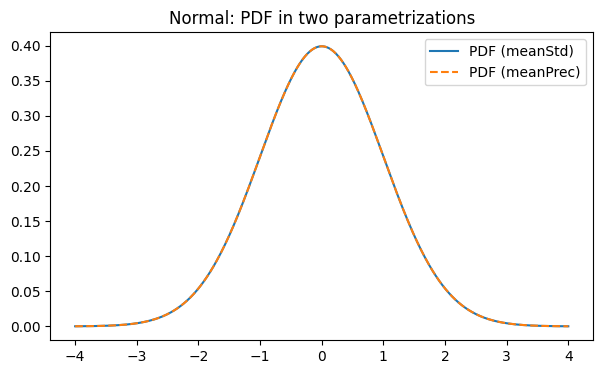

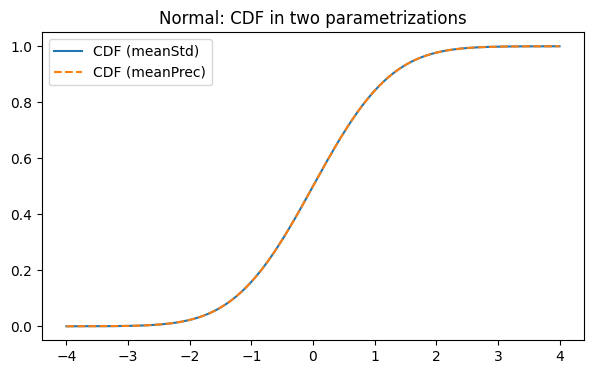

In [7]:
x = np.linspace(-4, 4, 600)

pdf_std = d_mean_std.query_method(CharacteristicName.PDF)
cdf_std = d_mean_std.query_method(CharacteristicName.CDF)

pdf_prec = d_mean_prec.query_method(CharacteristicName.PDF)
cdf_prec = d_mean_prec.query_method(CharacteristicName.CDF)

plt.figure(figsize=(7, 4))
plt.plot(x, pdf_std(x), label="PDF (meanStd)")
plt.plot(x, pdf_prec(x), linestyle="--", label="PDF (meanPrec)")
plt.legend()
plt.title("Normal: PDF in two parametrizations")
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(x, cdf_std(x), label="CDF (meanStd)")
plt.plot(x, cdf_prec(x), linestyle="--", label="CDF (meanPrec)")
plt.legend()
plt.title("Normal: CDF in two parametrizations")
plt.show()

### Sampling

For the Normal distribution, sampling is provided via the high-level
`distribution.sample(...)` interface.

Internally, the sampling strategy may rely on analytical characteristics
(such as `PPF` for inverse transform sampling), but this detail is hidden
from the user. The recommended way to generate samples is always through
`sample(...)`, which ensures a consistent and efficient implementation.

At the moment, this only works with characteristics with NumPy semantics (so not graph computed).


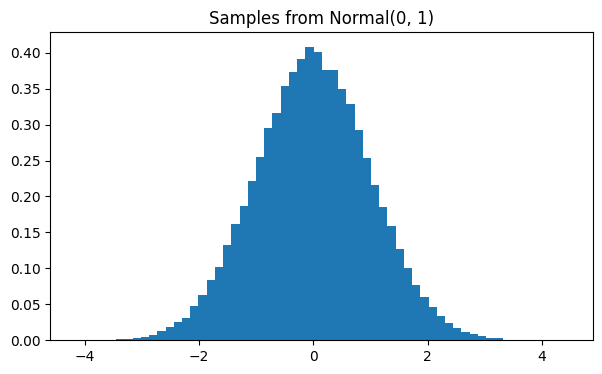

In [8]:
samples = d_mean_std.sample(n=100_000)

plt.figure(figsize=(7, 4))
plt.hist(samples, bins=60, density=True)
plt.title("Samples from Normal(0, 1)")
plt.show()

## 2) Custom family with multiple parametrizations

In this section we create a custom family and **register** it in `ParametricFamilyRegister`.

We implement a simple distribution on an interval `[a, b]` with CDF
`F(x) = ((x-a)/(b-a))^2` for `x ∈ [a, b]` (and 0/1 outside), which corresponds to the PDF
`f(x) = 2(x-a)/(b-a)^2` on `[a, b]`.

We provide **PDF** and **CDF** analytically for both parametrizations, but omit **PPF**.
Then we query `PPF` via the characteristic graph.

Parametrizations:

- `endpoints`: `(a, b)`
- `locScale`: `(loc, scale)` where `a = loc`, `b = loc + scale`


**Important note (current limitation).**

Built-in families provide analytical characteristics that follow **NumPy semantics** (arrays in / arrays out).
Graph-based conversions (fitted methods from `fitters.py`) are currently **scalar-only**.

That means that a derived characteristic like `PPF` may only accept Python floats. If you pass a NumPy array,
SciPy routines used inside conversions (e.g. `scipy.integrate.quad`) may fail with errors such as
`ValueError: The truth value of an array with more than one element is ambiguous`.

Until the fitters are upgraded to NumPy semantics, evaluate derived characteristics pointwise.


In [9]:
def _ab(params: Parametrization) -> tuple[float, float]:
    if hasattr(params, "a") and hasattr(params, "b"):
        return float(params.a), float(params.b)
    return float(params.loc), float(params.loc + params.scale)


def tri_pdf(params: Parametrization, x: np.ndarray) -> np.ndarray:
    a, b = _ab(params)
    x = np.asarray(x, dtype=np.float64)
    denom = b - a
    y = 2.0 * (x - a) / (denom * denom)
    y[(x < a) | (x > b)] = 0.0
    return y


def tri_cdf(params: Parametrization, x: np.ndarray) -> np.ndarray:
    a, b = _ab(params)
    x = np.asarray(x, dtype=np.float64)
    denom = b - a
    t = (x - a) / denom
    return np.where(x <= a, 0.0, np.where(x >= b, 1.0, t * t))


def tri_support(params: Parametrization) -> ContinuousSupport:
    a, b = _ab(params)
    return ContinuousSupport(a, b)

In [10]:
tri_family = ParametricFamily(
    name="TriangularAB",
    distr_type=UnivariateContinuous,
    distr_parametrizations=["endpoints", "locScale"],
    distr_characteristics={
        CharacteristicName.PDF: {
            "endpoints": tri_pdf,
            "locScale": tri_pdf,
        },
        CharacteristicName.CDF: {
            "endpoints": tri_cdf,
            "locScale": tri_cdf,
        },
        # PPF intentionally omitted: it will be derived by the graph.
    },
    support_by_parametrization=tri_support,
)


@parametrization(family=tri_family, name="endpoints")
class Endpoints(Parametrization):
    a: float
    b: float


@tri_family.parametrization(name="locScale")
class LocScale(Parametrization):
    loc: float
    scale: float


# Register the family so that the computation strategy can resolve it by name
ParametricFamilyRegister.register(tri_family)
ParametricFamilyRegister.get("TriangularAB").name

'TriangularAB'

In [11]:
tri_endpoints = tri_family.distribution(parametrization_name="endpoints", a=0.0, b=1.0)
tri_locscale = tri_family.distribution(parametrization_name="locScale", loc=0.0, scale=1.0)
tri_endpoints.parametrization_name, tri_locscale.parametrization_name

('endpoints', 'locScale')

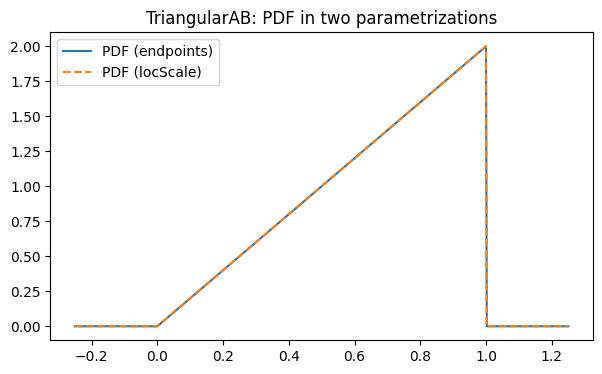

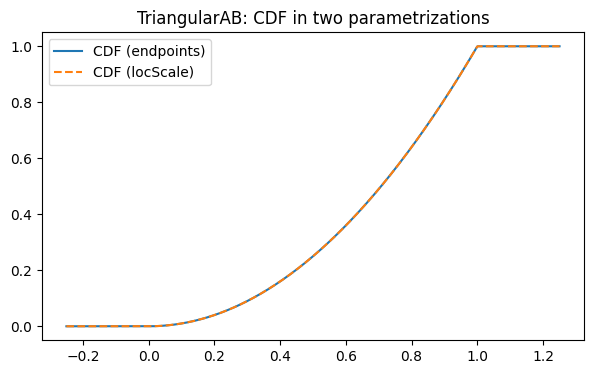

In [12]:
x01 = np.linspace(-0.25, 1.25, 600)

pdf_e = tri_endpoints.query_method(CharacteristicName.PDF)
cdf_e = tri_endpoints.query_method(CharacteristicName.CDF)
pdf_l = tri_locscale.query_method(CharacteristicName.PDF)
cdf_l = tri_locscale.query_method(CharacteristicName.CDF)

plt.figure(figsize=(7, 4))
plt.plot(x01, pdf_e(x01), label="PDF (endpoints)")
plt.plot(x01, pdf_l(x01), linestyle="--", label="PDF (locScale)")
plt.legend()
plt.title("TriangularAB: PDF in two parametrizations")
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(x01, cdf_e(x01), label="CDF (endpoints)")
plt.plot(x01, cdf_l(x01), linestyle="--", label="CDF (locScale)")
plt.legend()
plt.title("TriangularAB: CDF in two parametrizations")
plt.show()

In [13]:
def eval_scalar_method_on_array(method, xs):
    xs = np.asarray(xs, dtype=np.float64)
    return np.array([method(float(x)) for x in xs], dtype=np.float64)

### Querying a derived PPF (scalar-only)

We now request `PPF`. Since we did not provide it analytically, it is derived via the characteristic graph.
At the moment, this derived method is scalar-only, so we evaluate it pointwise for a vector of probabilities.


In [14]:
ppf_e = tri_endpoints.query_method(CharacteristicName.PPF)
ppf_l = tri_locscale.query_method(CharacteristicName.PPF)

qs = np.array([0.1, 0.25, 0.5, 0.75, 0.9])
q_endpoints = np.array([ppf_e(float(q)) for q in qs], dtype=np.float64)
q_locscale = np.array([ppf_l(float(q)) for q in qs], dtype=np.float64)
np.column_stack([qs, q_endpoints, q_locscale])

array([[0.1       , 0.31622777, 0.31622777],
       [0.25      , 0.5       , 0.5       ],
       [0.5       , 0.70710678, 0.70710678],
       [0.75      , 0.8660254 , 0.8660254 ],
       [0.9       , 0.9486833 , 0.9486833 ]])

### Summary

- Built-in families: analytical methods support NumPy arrays.
- Custom family: we registered it in the global registry.
- We provided vectorized `PDF` and `CDF`.
- We omitted `PPF`, and obtained it via the characteristic graph.
- Graph-derived methods are currently scalar-only, so we evaluated them pointwise.
